In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

In [2]:
df = pd.read_csv("./creditcard.csv", sep=',')
print(df.head())
print(df.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

In [5]:
df.isnull().values.any() #check to see if any values are null, which there are not
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

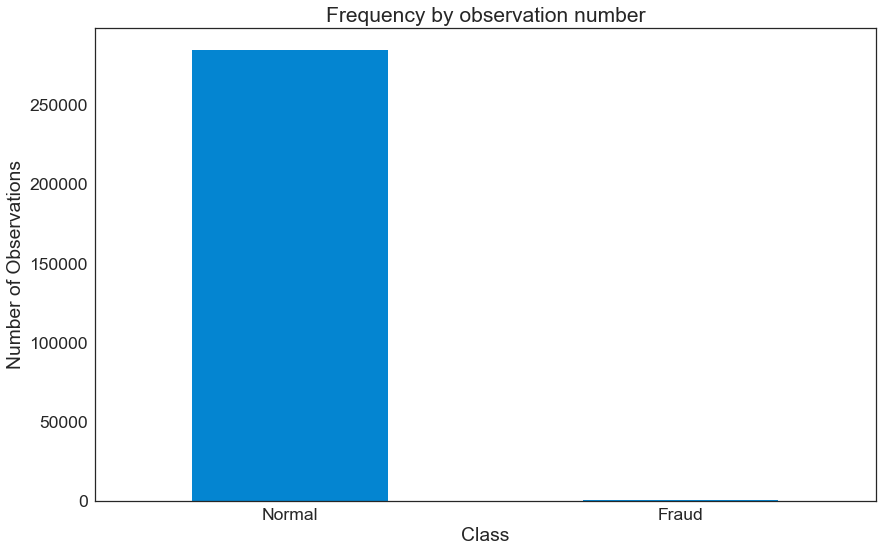

In [7]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");
plt.show()

In [10]:
normal_df = df[df.Class == 0]
fraud_df = df[df.Class == 1]
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

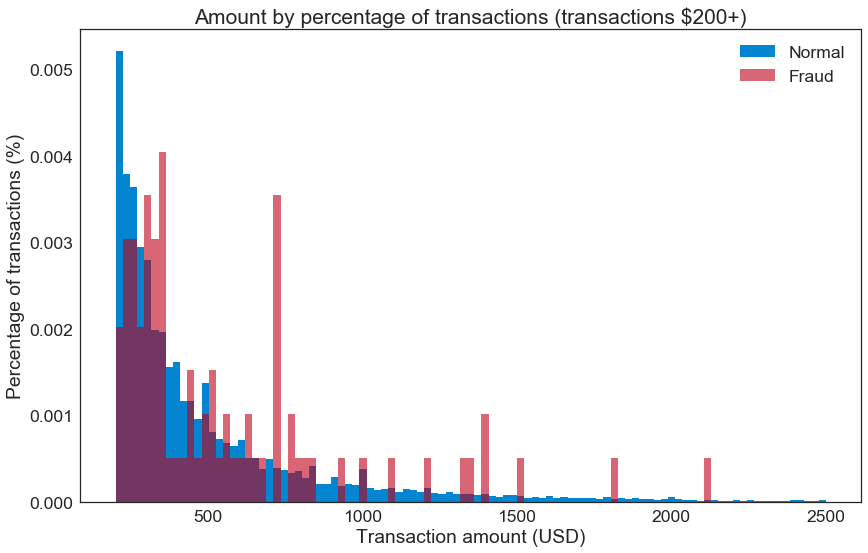

In [11]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

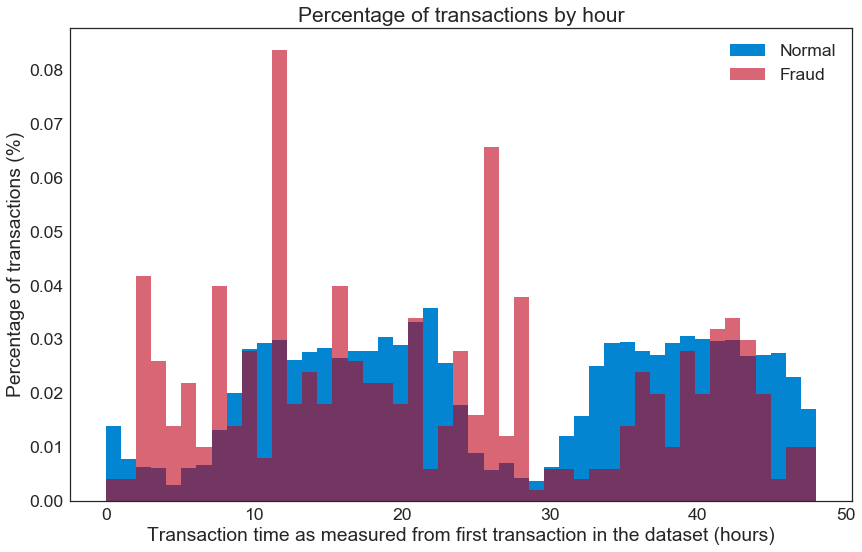

In [12]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

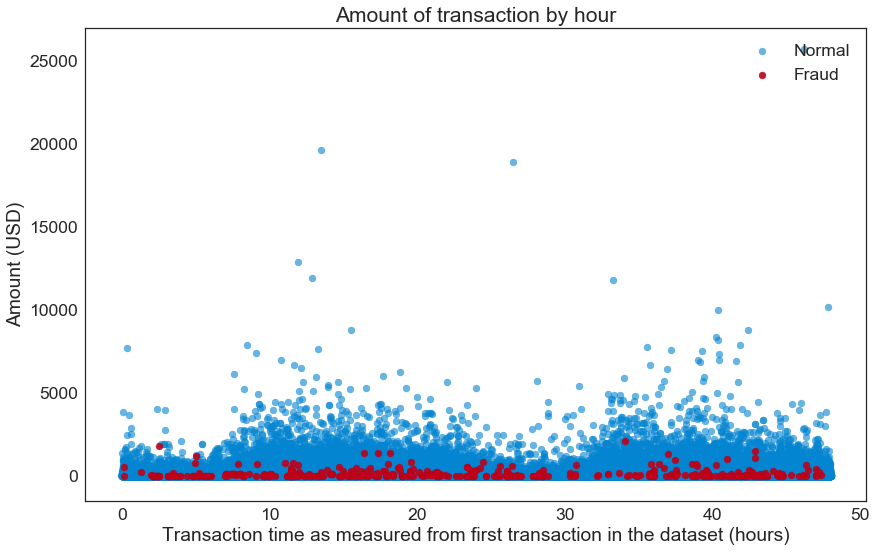

In [13]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [14]:
# data normalzation
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [15]:
# split test and train dataset
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values
print(train_x.shape)

(227468, 30)


In [18]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 3s 14us/step - loss: 0.8686 - acc: 0.4582 - val_loss: 0.8257 - val_acc: 0.5834
Epoch 2/100
227468/227468 [==============================] - 3s 14us/step - loss: 0.7637 - acc: 0.6117 - val_loss: 0.7811 - val_acc: 0.6273
Epoch 3/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7379 - acc: 0.6366 - val_loss: 0.7661 - val_acc: 0.6393
Epoch 4/100
227468/227468 [==============================] - 3s 14us/step - loss: 0.7278 - acc: 0.6508 - val_loss: 0.7589 - val_acc: 0.6519
Epoch 5/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.7218 - acc: 0.6609 - val_loss: 0.7541 - val_acc: 0.6609
Epoch 6/100
227468/227468 [==============================] - 3s 15us/step - loss: 0.7167 - acc: 0.6643 - val_loss: 0.7500 - val_acc: 0.6629
Epoch 7/100
227468/227468 [==============================] - 3s 15us/step - loss: 0.7136 - acc: 0.6690 - val_

Epoch 59/100
227468/227468 [==============================] - 3s 11us/step - loss: 0.6957 - acc: 0.6885 - val_loss: 0.7307 - val_acc: 0.6862
Epoch 60/100
227468/227468 [==============================] - 3s 11us/step - loss: 0.6956 - acc: 0.6896 - val_loss: 0.7306 - val_acc: 0.6839
Epoch 61/100
227468/227468 [==============================] - 3s 14us/step - loss: 0.6954 - acc: 0.6899 - val_loss: 0.7312 - val_acc: 0.6919
Epoch 62/100
227468/227468 [==============================] - 3s 15us/step - loss: 0.6953 - acc: 0.6904 - val_loss: 0.7315 - val_acc: 0.6928
Epoch 63/100
227468/227468 [==============================] - 3s 15us/step - loss: 0.6954 - acc: 0.6911 - val_loss: 0.7306 - val_acc: 0.6917
Epoch 64/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.6952 - acc: 0.6919 - val_loss: 0.7313 - val_acc: 0.6966
Epoch 65/100
227468/227468 [==============================] - 5s 21us/step - loss: 0.6953 - acc: 0.6912 - val_loss: 0.7304 - val_acc: 0.6922
Epoch 66/100


In [19]:
autoencoder = load_model('autoencoder_fraud.h5')

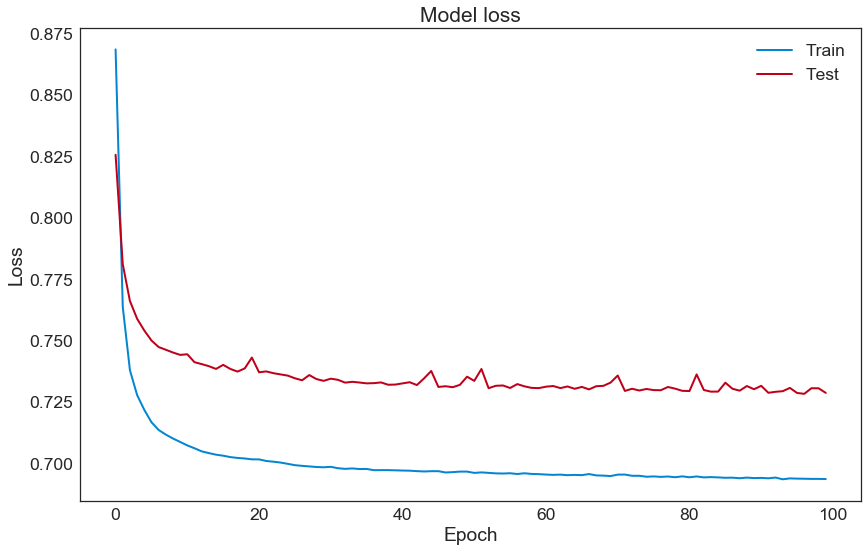

In [22]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [23]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.728191,0.002019
std,3.104733,0.044887
min,0.045383,0.000000
25%,0.246430,0.000000
50%,0.394651,0.000000
75%,0.620397,0.000000
max,197.381785,1.000000


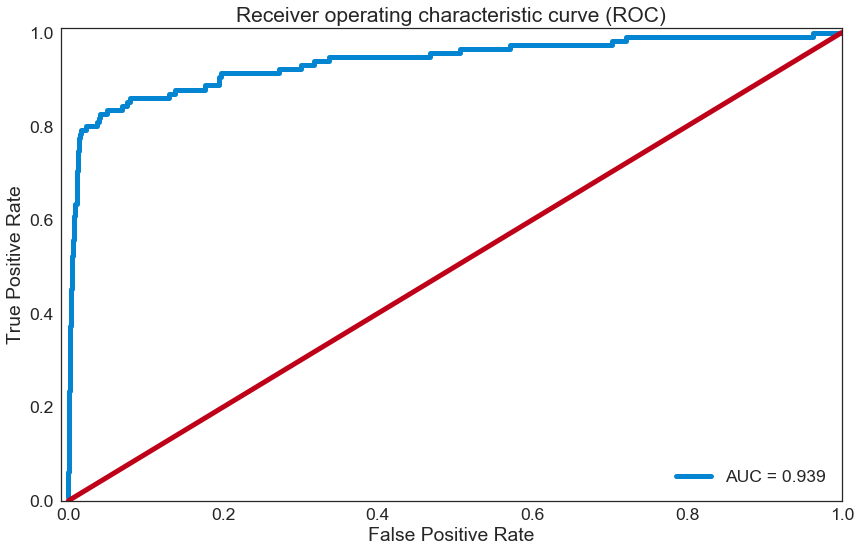

In [24]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

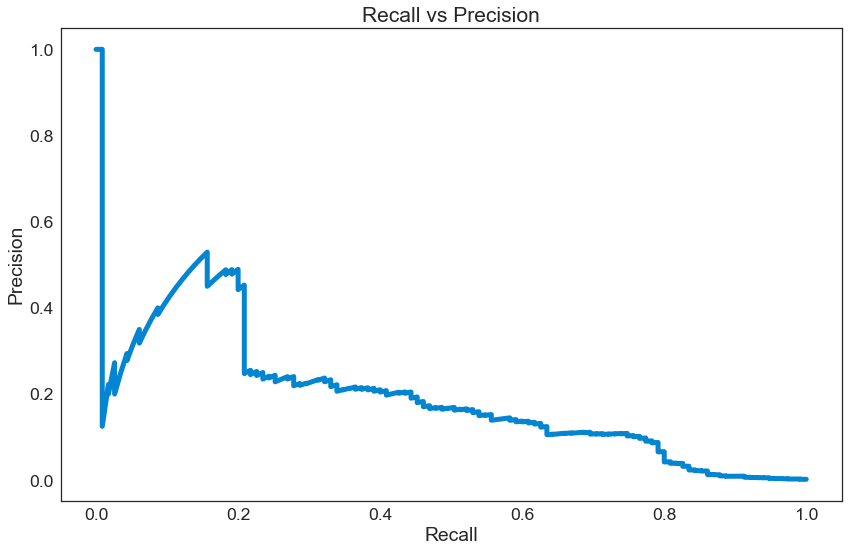

In [25]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

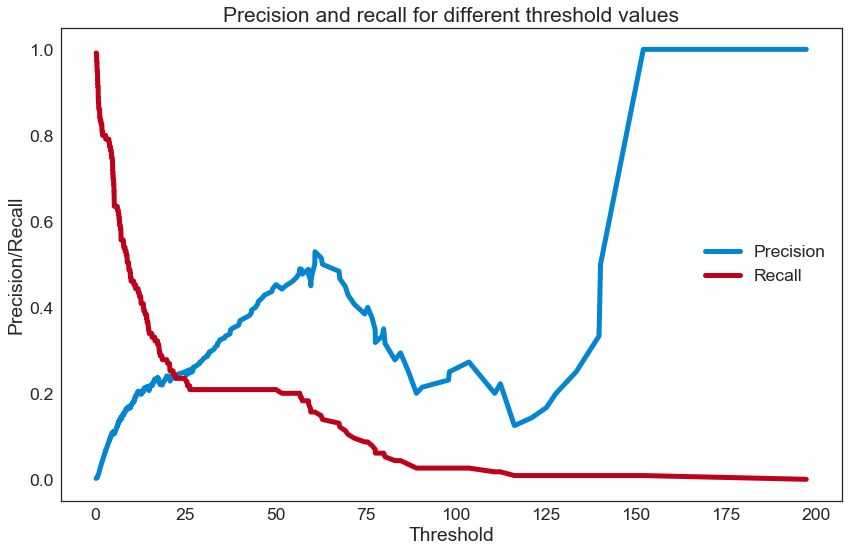

In [26]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

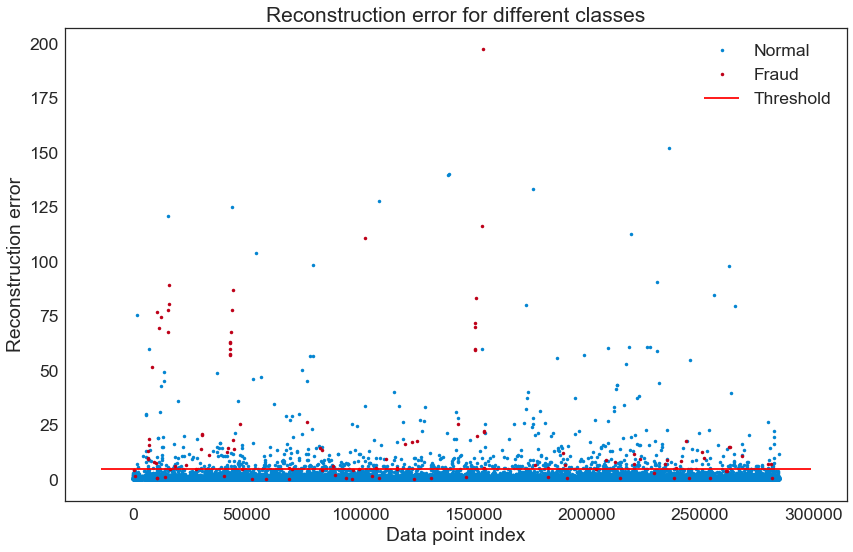

In [27]:
threshold_fixed = 5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

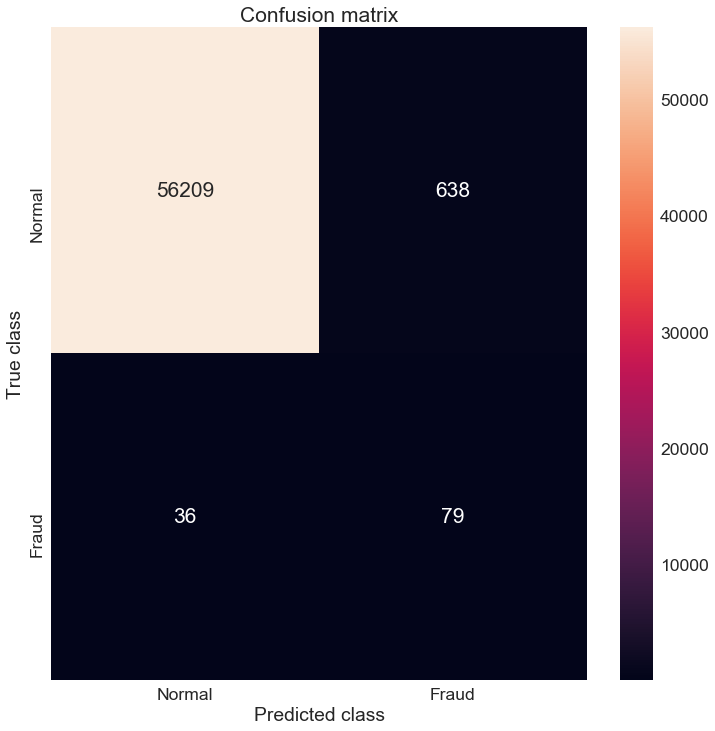

In [28]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()